In [13]:
import os
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [14]:
PROJECT_ROOT = Path.cwd().parent       # 当前工作目录
DATA_ROOT    = PROJECT_ROOT / "data"

DATA_RAW      = DATA_ROOT / "raw"        # 原始 Totalsegmentator 数据（每个病人一个文件夹）
DATA_SYMM     = DATA_ROOT / "symmetric"  # 筛出左右体积接近的
DATA_COMPLETE = DATA_ROOT / "complete"   # KMeans 判为 complete 的
DATA_PARTIAL  = DATA_ROOT / "partial"    # 判为 partial 的
DATA_RAS      = DATA_ROOT / "ras_3mm"    # RAS+1mm 输出

CSV_DIR       = DATA_ROOT / "csv"
FIG_DIR       = DATA_ROOT / "fig"

for p in [DATA_SYMM, DATA_COMPLETE, DATA_PARTIAL, DATA_RAS, CSV_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# 原 Totalsegmentator 里用到的结构文件名
REQUIRED_FILES = {
    "left_scapula":  "scapula_left.nii.gz",
    "right_scapula": "scapula_right.nii.gz",
    "left_humerus":  "humerus_left.nii.gz",
    "right_humerus": "humerus_right.nii.gz",
}

In [15]:
def load_nifti(path: Path) -> nib.Nifti1Image:
    return nib.load(str(path))


def compute_volume_ml(img: nib.Nifti1Image) -> float:
    """体积，单位 ml"""
    data = img.get_fdata()
    spacing = img.header.get_zooms()  # mm
    voxel_vol_mm3 = np.prod(spacing)
    vol_ml = (data > 0).sum() * voxel_vol_mm3 / 1000.0  # 1 ml = 1000 mm3
    return float(vol_ml)


def ensure_seg_paths(patient_dir: Path) -> dict:
    seg = patient_dir / "segmentations"
    paths = {}
    for key, fn in REQUIRED_FILES.items():
        p = seg / fn
        paths[key] = p if p.exists() else None
    return paths

In [16]:
def compute_volumes_for_all_patients():
    records = []
    for pdir in sorted(DATA_RAW.glob("s*")):
        paths = ensure_seg_paths(pdir)
        row = {"patient": pdir.name}
        for key, p in paths.items():
            if p is None:
                row[key] = np.nan
            else:
                row[key] = compute_volume_ml(load_nifti(p))
        records.append(row)

    df = pd.DataFrame(records)
    out_csv = CSV_DIR / "volumes_raw.csv"
    df.to_csv(out_csv, index=False)
    print(f"[volume] saved to {out_csv}")
    return df


def within_ratio(a, b, tol=0.10) -> bool:
    if np.isnan(a) or np.isnan(b) or a == 0 or b == 0:
        return False
    return abs(a - b) / max(a, b) < tol


def filter_symmetric_pairs(df: pd.DataFrame, tol=0.10):
    df = df.copy()
    df["scapula_sym"] = df.apply(
        lambda r: within_ratio(r["left_scapula"], r["right_scapula"], tol), axis=1
    )
    df["humerus_sym"] = df.apply(
        lambda r: within_ratio(r["left_humerus"], r["right_humerus"], tol), axis=1
    )
    df_sym = df[df["scapula_sym"] & df["humerus_sym"]].reset_index(drop=True)

    out_csv = CSV_DIR / "volumes_symmetric.csv"
    df_sym.to_csv(out_csv, index=False)
    print(f"[symmetric] saved to {out_csv}")

    # 同时把这些病人拷贝到 DATA_SYMM
    for pid in df_sym["patient"]:
        src = DATA_RAW / pid
        dst = DATA_SYMM / pid
        if not dst.exists():
            shutil.copytree(src, dst)
    print(f"[symmetric] copied patients to {DATA_SYMM}")

    return df_sym

In [17]:
def plot_humerus_violin_complete_vs_partial(df_clustered):
    """
    violin plot:
    - complete group humerus volume (left & right)
    - partial group humerus volume (left & right)
    """
    df = df_clustered.copy()

    # long format
    v_records = []
    for _, r in df.iterrows():
        for side in ["left_humerus", "right_humerus"]:
            v_records.append({
                "patient": r["patient"],
                "group": r["group"],
                "side": side,
                "volume": r[side]
            })

    df_long = pd.DataFrame(v_records)

    # 绘图
    fig, ax = plt.subplots(figsize=(8, 5))
    groups = ["complete", "partial"]
    data = [
        df_long[(df_long["group"] == g)]["volume"].values
        for g in groups
    ]

    ax.violinplot(data, showmeans=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(groups)
    ax.set_ylabel("Humerus Volume (ml)")
    ax.set_title("Humerus Volume: complete vs partial")

    fig.tight_layout()
    out = FIG_DIR / "violin_humerus_complete_vs_partial.png"
    fig.savefig(out, dpi=300)
    plt.close(fig)
    print(f"[violin] saved to {out}")


def cluster_completeness(df_vol: pd.DataFrame, n_clusters: int = 2):
    df = df_vol.copy()
    df["humerus_max_vol"] = df[["left_humerus", "right_humerus"]].max(axis=1)

    # KMeans 只用 humerus 体积
    X = df["humerus_max_vol"].values.reshape(-1, 1)
    km = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    labels = km.fit_predict(X)
    df["cluster"] = labels

    # 体积大的 cluster 视为 complete
    cluster_means = df.groupby("cluster")["humerus_max_vol"].mean()
    complete_cluster = cluster_means.idxmax()
    df["group"] = df["cluster"].apply(
        lambda c: "complete" if c == complete_cluster else "partial"
    )

    out_csv = CSV_DIR / "volumes_clustered.csv"
    df.to_csv(out_csv, index=False)
    print(f"[cluster] saved to {out_csv}")

    # 拷贝到 complete / partial 目录，只保留需要的 4 个结构
    for _, row in df.iterrows():
        src = DATA_SYMM / row["patient"]
        dst_root = DATA_COMPLETE if row["group"] == "complete" else DATA_PARTIAL
        dst = dst_root / row["patient"]
        if dst.exists():
            continue
        shutil.copytree(src, dst)
        seg_dir = dst / "segmentations"
        for fn in seg_dir.iterdir():
            if fn.name not in REQUIRED_FILES.values():
                fn.unlink()
    print(f"[cluster] copied to {DATA_COMPLETE} & {DATA_PARTIAL}")
    return df


In [18]:
import os
from pathlib import Path

import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ============================================
# 路径配置：假定当前在 registration_project/src 里跑
# ============================================
cwd = Path.cwd()
if (cwd / "data").exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / "data").exists():
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd  # 若结构不同，你可以改成绝对路径

DATA_COMPLETE = PROJECT_ROOT / "data" / "complete"
DATA_RAS      = PROJECT_ROOT / "data" / "ras_1mm"
FIG_DIR       = PROJECT_ROOT / "data" / "fig"
FIG_DIR.mkdir(parents=True, exist_ok=True)
DATA_RAS.mkdir(parents=True, exist_ok=True)

STRUCTS = [
    "scapula_left.nii.gz",
    "scapula_right.nii.gz",
    "humerus_left.nii.gz",
    "humerus_right.nii.gz",
]

MAX_VIS_3D = 30000  # 3D 散点可视化最多点数


# ============================================
# 工具：mask → world 点云（沿用你 notebook 的写法）
# ============================================
def mask_to_world_points(mask, affine):
    ijk = np.array(np.where(mask > 0)).T
    if ijk.shape[0] == 0:
        return np.zeros((0, 3), dtype=float)
    ijk_h = np.c_[ijk, np.ones(len(ijk))]
    xyz = (ijk_h @ affine.T)[:, :3]
    return xyz


# ============================================
# PCA 严格对齐：PC1→+X, PC2→+Y, PC3→+Z
# （直接搬你的 align_pca_strict）
# ============================================
def align_pca_strict(points):
    mean = points.mean(axis=0)
    pts_centered = points - mean

    pca = PCA(3).fit(pts_centered)
    basis = pca.components_  # PC1, PC2, PC3

    # PC1 朝 +X
    if basis[0, 0] < 0:
        basis[0] = -basis[0]
    # PC2 朝 +Y
    if basis[1, 1] < 0:
        basis[1] = -basis[1]

    # PC3 = PC1 × PC2（正交）
    pc1 = basis[0]
    pc2 = basis[1]
    pc3 = np.cross(pc1, pc2)
    pc3 = pc3 / np.linalg.norm(pc3)

    R = np.vstack([pc1, pc2, pc3])
    aligned = pts_centered @ R.T
    return aligned, R, mean


# ============================================
# 3D before/after 可视化（可选，不想看可以注释掉）
# ============================================
def visualize_3d(before, after, title=""):
    if before.shape[0] > MAX_VIS_3D:
        idx = np.random.choice(before.shape[0], MAX_VIS_3D, replace=False)
        before = before[idx]
        after = after[idx]

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121, projection="3d")
    ax1.scatter(before[:, 0], before[:, 1], before[:, 2], s=0.5, alpha=0.4, c='blue')
    ax1.set_title("Before")
    ax1.set_xlabel("X"); ax1.set_ylabel("Y"); ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(122, projection="3d")
    ax2.scatter(after[:, 0], after[:, 1], after[:, 2], s=0.5, alpha=0.4, c='red')
    ax2.set_title("After (PC1→+X, PC2→+Y)")
    ax2.set_xlabel("X"); ax2.set_ylabel("Y"); ax2.set_zlabel("Z")

    plt.suptitle(title)
    plt.show()


# ============================================
# Step A: 计算每个病人左右 scapula 的 PCA frame
# （origin_scap_dict, R_scap_dict）
# ============================================
def compute_scapula_frames():
    origin_scap_dict = {}
    R_scap_dict      = {}

    patients = sorted([p for p in DATA_COMPLETE.iterdir() if p.is_dir()])
    for pdir in patients:
        pid = pdir.name
        seg_dir = pdir / "segmentations"
        print(f"[PCA frame] {pid}")

        for side in ["left", "right"]:
            fname = seg_dir / f"scapula_{side}.nii.gz"
            if not fname.exists():
                print(f"  missing {fname.name}")
                continue

            img = nib.load(str(fname))
            mask = img.get_fdata() > 0
            pts = mask_to_world_points(mask, img.affine)
            if pts.shape[0] < 50:
                print(f"  too few points in {fname.name}, skip")
                continue

            aligned, R, mean = align_pca_strict(pts)

            # 如需 3D 质检可以解开下面一行
            # visualize_3d(pts - mean, aligned, title=f"{pid} — scapula_{side}")

            origin_scap_dict[(pid, side)] = mean
            R_scap_dict[(pid, side)]      = R

    return origin_scap_dict, R_scap_dict


# ============================================
# Step B: 根据 scapula frame 构造 RAS 变换（沿用你给的 build_RAS_transform）
# ============================================
def build_RAS_transform(R_scap, origin, is_left):
    """
    输入：
      R_scap: 来自 PCA 的 scapula frame (3x3)
      origin: PCA 中心
    输出：
      T (4x4): world → RAS 的仿射
    """
    Xs = R_scap[0]
    Ys = R_scap[1]
    Zs = R_scap[2]

    # Z 指向 +Z
    if Zs[2] < 0:
        Zs = -Zs
        Ys = -Ys

    # X 指向 +X
    if Xs[0] < 0:
        Xs = -Xs
        Ys = -Ys

    Ys = np.cross(Zs, Xs)
    Ys = Ys / np.linalg.norm(Ys)

    R_ras = np.vstack([Xs, Ys, Zs])

    T = np.eye(4)
    T[:3, :3] = R_ras
    T[:3, 3]  = -R_ras @ origin
    return T


# ============================================
# Step C: 用 SimpleITK 做 1mm 重采样（直接搬你的 resample_to_RAS_1mm）
# 这里把输出命名改成 scapula_left.nii.gz 等，方便后续使用
# ============================================
def resample_to_RAS_1mm(nifti_path, T, out_path):
    img_nib = nib.load(str(nifti_path))
    affine  = img_nib.affine

    # 新 affine = T @ 原 affine
    new_affine = T @ affine

    sitk_img = sitk.ReadImage(str(nifti_path))
    sitk_img.SetDirection(new_affine[:3, :3].flatten())
    sitk_img.SetOrigin(new_affine[:3, 3])

    spacing = [1.0, 1.0, 1.0]

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(spacing)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputDirection(sitk_img.GetDirection())
    resampler.SetOutputOrigin(sitk_img.GetOrigin())

    old_size    = np.array(sitk_img.GetSize())
    old_spacing = np.array(sitk_img.GetSpacing())
    new_size    = np.ceil(old_size * (old_spacing / spacing)).astype(int)
    resampler.SetSize(new_size.tolist())

    out_img = resampler.Execute(sitk_img)
    sitk.WriteImage(out_img, str(out_path))


def apply_RAS_and_resample_all(origin_scap_dict, R_scap_dict):
    patients = sorted([p for p in DATA_COMPLETE.iterdir() if p.is_dir()])

    for pdir in patients:
        pid = pdir.name
        print(f"\n=== RAS+1mm {pid} ===")
        seg_dir   = pdir / "segmentations"
        out_dir_p = DATA_RAS / pid
        out_dir_p.mkdir(parents=True, exist_ok=True)

        for side in ["right", "left"]:
            scap_file = seg_dir / f"scapula_{side}.nii.gz"
            hum_file  = seg_dir / f"humerus_{side}.nii.gz"

            if not scap_file.exists() or not hum_file.exists():
                continue

            key = (pid, side)
            if key not in origin_scap_dict:
                print(f"  no PCA frame for {pid},{side}, skip")
                continue

            origin = origin_scap_dict[key]
            R_scap = R_scap_dict[key]

            T_ras = build_RAS_transform(R_scap, origin, is_left=(side == "left"))

            # 输出命名不加后缀，直接 scapula_left.nii.gz
            out_scap = out_dir_p / f"scapula_{side}.nii.gz"
            resample_to_RAS_1mm(scap_file, T_ras, out_scap)

            out_hum = out_dir_p / f"humerus_{side}.nii.gz"
            resample_to_RAS_1mm(hum_file, T_ras, out_hum)


# ============================================
# Step D: PCA before/after RAS(2D)
# ============================================
def mask_to_world_from_file(path: Path):
    img = nib.load(str(path))
    mask = img.get_fdata() > 0
    return mask_to_world_points(mask, img.affine)


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from sklearn.decomposition import PCA
import random

def overlay_scatter_all_patients(structure="scapula", side="left"):
    """
    对所有病人的某一侧 scapula/humerus 做2D降维overlay（类似原始screening.ipynb效果）
    """

    patients = sorted([p.name for p in DATA_COMPLETE.iterdir() if p.is_dir()])
    all_pts = []
    pts_by_patient = []

    # 1. 收集所有点云
    for pid in patients:
        seg_path = DATA_RAS / pid / f"{structure}_{side}.nii.gz"
        if not seg_path.exists():
            print(f"skip {seg_path}")
            continue

        img = nib.load(str(seg_path)).get_fdata()
        pts = np.array(np.where(img > 0)).T
        if pts.shape[0] == 0:
            continue

        all_pts.append(pts)
        pts_by_patient.append((pid, pts))

    if len(all_pts) == 0:
        print(f"No valid RAS data for {structure} {side}")
        return
    
    # 2. 聚合点云做 PCA（用于2D projection）
    all_pts_concat = np.concatenate(all_pts, axis=0)
    pca = PCA(n_components=2).fit(all_pts_concat)

    # 3. 绘图
    plt.figure(figsize=(8, 8))
    colors = {}

    for pid, pts in pts_by_patient:
        if pid not in colors:
            colors[pid] = (random.random(), random.random(), random.random())

        proj = pca.transform(pts)
        plt.scatter(proj[:, 0], proj[:, 1], s=0.5, alpha=0.5, color=colors[pid], label=pid)

    plt.title(f"{structure}_{side} PCA 2D projection (all patients)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.gca().set_aspect("equal")

    out_path = FIG_DIR / f"{structure}_{side}_overlay_PCA2D.png"
    plt.savefig(out_path, dpi=300)
    plt.close()

    print(f"[overlay PCA] saved → {out_path}")


In [20]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def overlay_3d_points(pid, structure="scapula"):
    pdir = DATA_RAS / pid
    L = nib.load(str(pdir / f"{structure}_left.nii.gz"))
    R = nib.load(str(pdir / f"{structure}_right.nii.gz"))

    pts_L = np.array(np.where(L.get_fdata() > 0)).T
    pts_R = np.array(np.where(R.get_fdata() > 0)).T

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pts_L[:,0], pts_L[:,1], pts_L[:,2], s=0.5, c='red', alpha=0.5, label="Left")
    ax.scatter(pts_R[:,0], pts_R[:,1], pts_R[:,2], s=0.5, c='blue', alpha=0.5, label="Right")

    ax.set_title(f"3D Overlay of {structure} — {pid}")
    plt.legend()
    plt.show()


In [21]:
def main_before_manual_check():
    print("PROJECT_ROOT:", PROJECT_ROOT)
    print("DATA_ROOT   :", DATA_ROOT)

    # 1) 体积统计
    df_vol = compute_volumes_for_all_patients()

    # completeness 聚类 + violin 对称筛选
    df_sym = filter_symmetric_pairs(df_vol, tol=0.10)
    df_clustered = cluster_completeness(df_sym)
    plot_humerus_violin_complete_vs_partial(df_clustered)


In [22]:
#main_before_manual_check()

PROJECT_ROOT: C:\Users\lenovo\Documents\registration_project
DATA_ROOT   : C:\Users\lenovo\Documents\registration_project\data



KeyboardInterrupt



Manual acquisition pose check and real outlier clean

In [11]:
def main_after_manual_check():
    # 1) 为所有 complete 病人的左右 scapula 建 PCA frame
    origin_scap_dict, R_scap_dict = compute_scapula_frames()

    # 2) 用这些 frame 做 RAS + 1mm 重采样，写入 data/ras_1mm
    apply_RAS_and_resample_all(origin_scap_dict, R_scap_dict)

    # 3) 所有病人 scapula/humerus 的 PCA before/after RAS
    #visualize_PCA_all_patients_before_after("scapula")
    #visualize_PCA_all_patients_before_after("humerus")

    # 4) 选第一个病人，做左右 overlay 质检
    patients = sorted([p.name for p in DATA_COMPLETE.iterdir() if p.is_dir()])

    for pid in patients:
        print(f"[3D overlay] Processing {pid} ...")
        overlay_3d_points(pid, "scapula")
        overlay_3d_points(pid, "humerus")
    # 5) 多病人 overlay 2D PCA 对比
        overlay_scatter_all_patients("scapula", "left")
        overlay_scatter_all_patients("scapula", "right")
        overlay_scatter_all_patients("humerus", "left")
        overlay_scatter_all_patients("humerus", "right")



[PCA frame] s0970
[PCA frame] s1029
[PCA frame] s1124
[PCA frame] s1350

=== RAS+1mm s0970 ===

=== RAS+1mm s1029 ===

=== RAS+1mm s1124 ===

=== RAS+1mm s1350 ===
[3D overlay] Processing s0970 ...


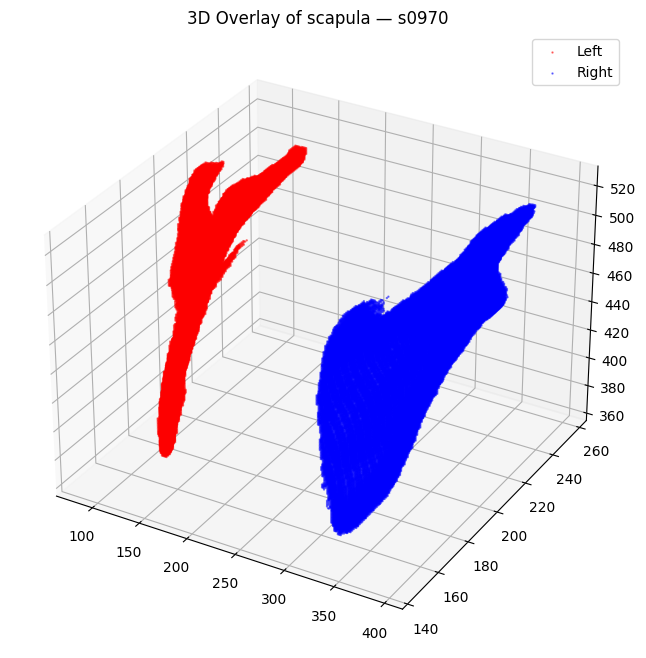

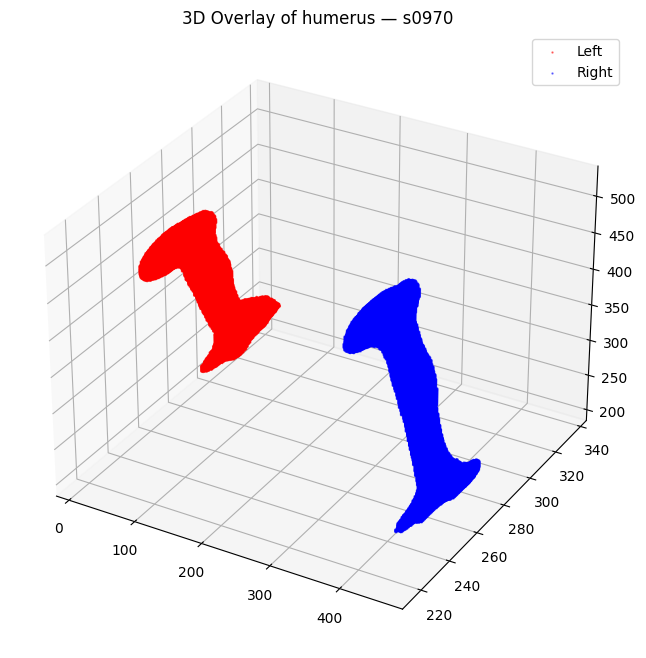

[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_right_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_right_overlay_PCA2D.png
[3D overlay] Processing s1029 ...


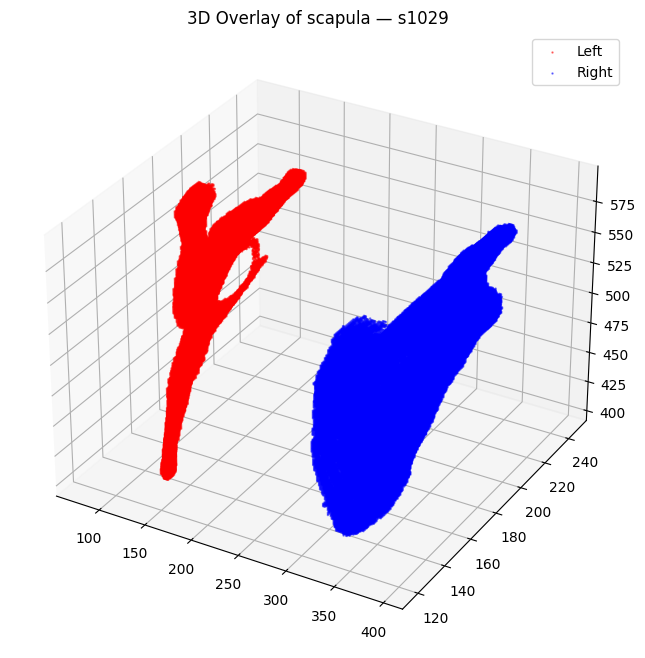

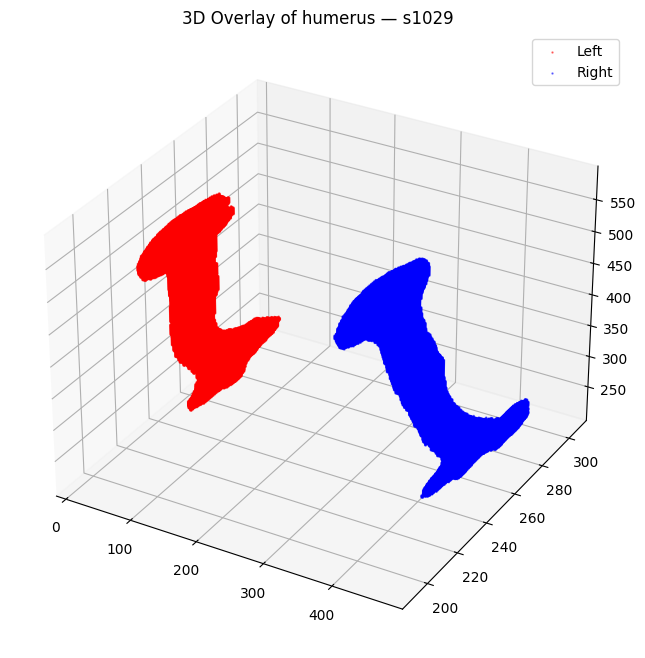

[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_right_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_right_overlay_PCA2D.png
[3D overlay] Processing s1124 ...


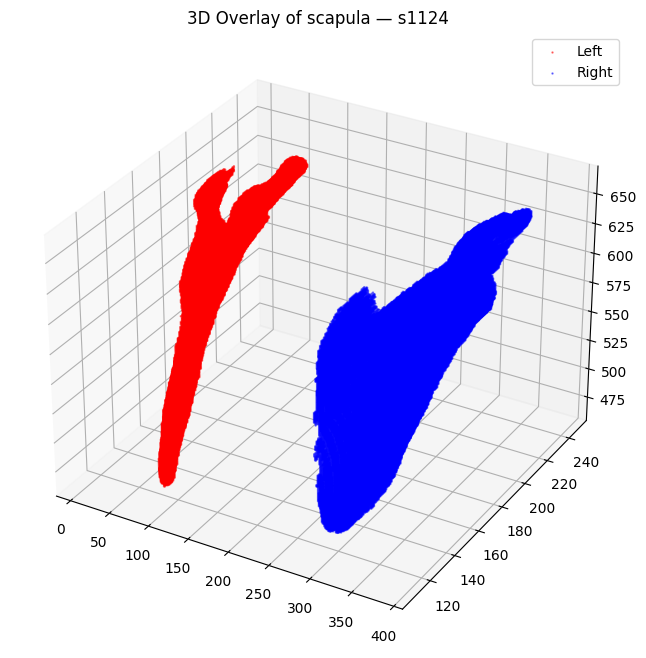

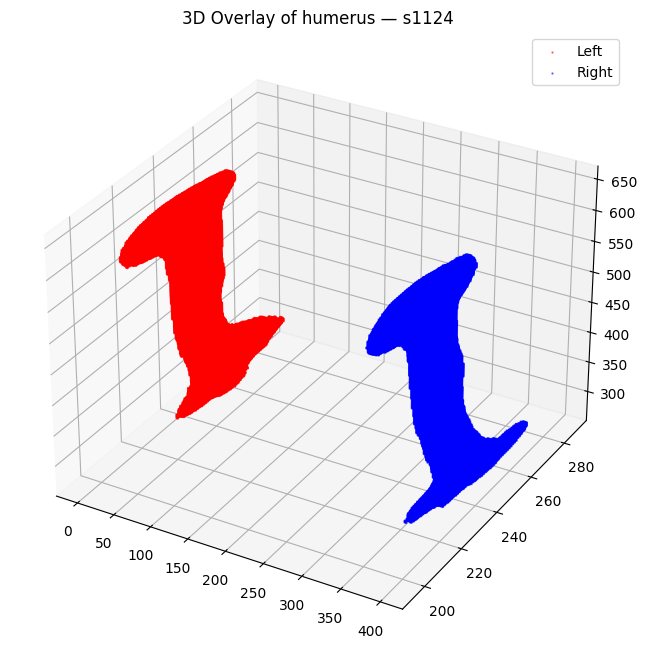

[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_right_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_right_overlay_PCA2D.png
[3D overlay] Processing s1350 ...


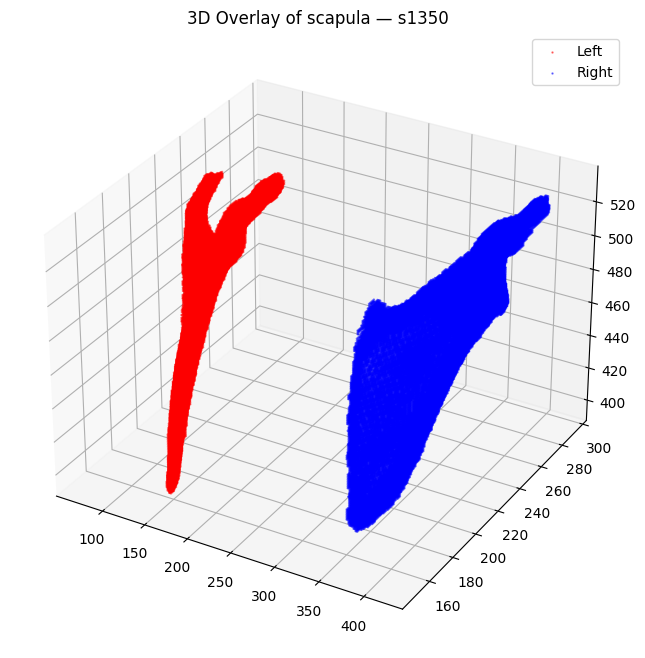

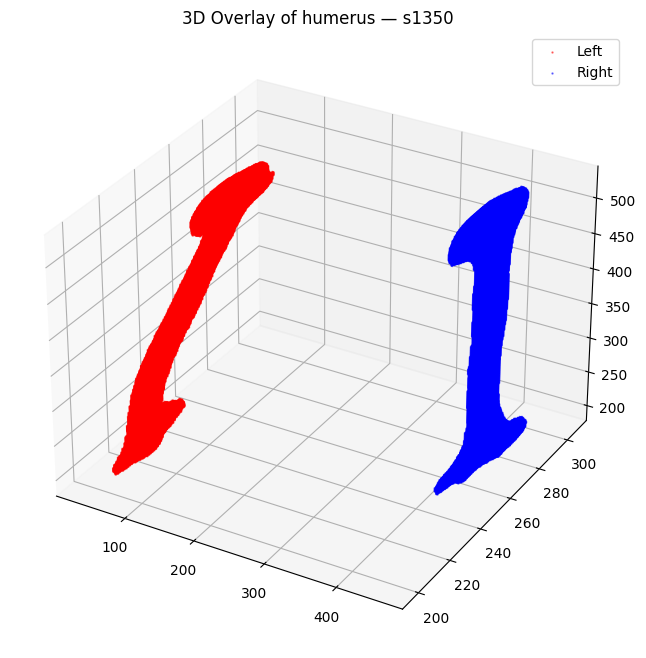

[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\scapula_right_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_left_overlay_PCA2D.png
[overlay PCA] saved → C:\Users\lenovo\Documents\registration_project\data\fig\humerus_right_overlay_PCA2D.png


In [12]:
main_after_manual_check()